# Notebook Imports

In [337]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
%matplotlib inline

# Constants

In [338]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt"
SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"
SPAM_CAT = 1
HAM_CAT = 0
DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json."

# Reading Files

In [339]:
stream = open(EXAMPLE_FILE, encoding = "latin-1")
message = stream.read()
stream.close()
#print(type(message))
#print(message)

In [340]:
#import sys
#sys.getfilesystemencoding()

In [341]:
stream = open(EXAMPLE_FILE, encoding = "latin-1")
is_body = False
lines = []
for line in stream:
    if is_body:
        lines.append(line)
    elif line == "\n":
        is_body = True
stream.close()

email_body = "\n".join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [342]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [343]:
for i in generate_squares(5):
    print(i, end = "->")

0->1->4->9->16->

# Email body extraction

In [344]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            stream = open(filepath, encoding = "latin-1")
            is_body = False
            lines = []
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == "\n":
                    is_body = True
            stream.close()

            email_body = "\n".join(lines)
            yield file_name, email_body

In [345]:
def df_from_directory(path, classification):
    rows= []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({"MESSAGE": email_body, "CATEGORY": classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index = row_names)

In [346]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails.head()
#spam_emails.shape

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [347]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
ham_emails.head()
ham_emails.shape

(3901, 2)

In [348]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is: ", data.shape)
data.head()

Shape of entire dataframe is:  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [349]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning: Checking for Missing Values

In [350]:
# check if any message bodies are null
data["MESSAGE"].isnull().values.any()
(data.MESSAGE.isnull() == True).sum()
(data.MESSAGE.isnull()).sum()

0

In [351]:
# check if there are empty emails ( string length zero)
data.MESSAGE.str.len().values.any()
(data.MESSAGE.str.len() == 0).sum()

3

## Locate empty emails

In [352]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [353]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [354]:
data.index.get_loc("cmds")
data[4608 : 4611]

,MESSAGE,CATEGORY
00210.ca401834d76bbedb98e548160e2ab559,I have a strange problem with one user in a sm...,0
00211.835ec23b746b6aede4e2e15ced421bb4,"I just heard from Kevin Patrick Scannell, auth...",0
00212.df5211161d938a2547804a50f0a8698f,"At 17:34 31/07/02 +0100, Liam Bedford wrote:\n...",0


# Remove System File Entries from Dataframe

In [355]:
data.drop(["cmds"], inplace = True)

In [356]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [357]:
document_ids = range(0, len(data.index))
data["DOC_ID"] = document_ids

In [358]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


# Save to File using Pandas

In [359]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [360]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [361]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

In [362]:
#category_names = ["Spam", "Legit Mail"]
#sizes = [amount_of_spam, amount_of_ham]
#plt.figure(figsize = (2,2), dpi = 230)
#plt.pie(sizes, labels = category_names, textprops = {"fontsize" : 6}, startangle = 90, autopct = "%1.0f%%")
#plt.show()

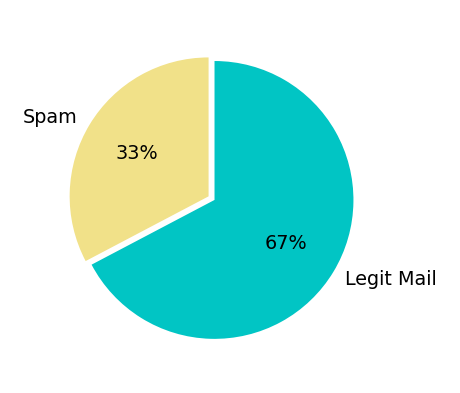

In [363]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#f1e189","#01c5c4"]
plt.figure(figsize = (2,2), dpi = 230)
plt.pie(sizes, labels = category_names, textprops = {"fontsize" : 6}, startangle = 90, autopct = "%1.0f%%",
        colors = custom_colours, explode = [0, 0.05])
plt.show()

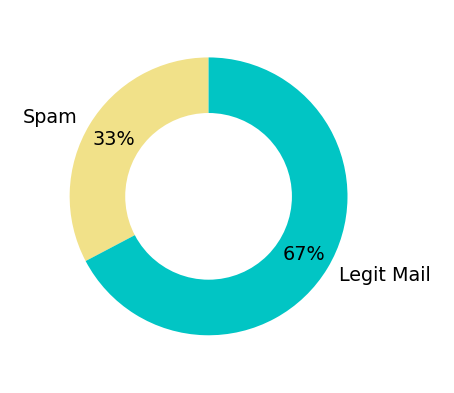

In [364]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#f1e189","#01c5c4"]
plt.figure(figsize = (2,2), dpi = 230)
plt.pie(sizes, labels = category_names, textprops = {"fontsize" : 6}, startangle = 90, autopct = "%1.0f%%",
        colors = custom_colours, pctdistance = 0.8)

# draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc = "white")
plt.gca().add_artist(centre_circle)
plt.show()

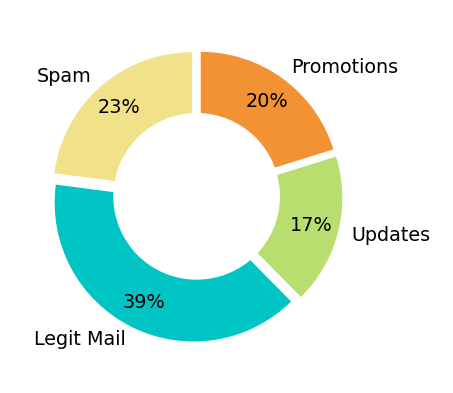

In [365]:
category_names = ["Spam", "Legit Mail", "Updates", "Promotions"]
sizes = [25, 43, 19, 22]
custom_colours = ["#f1e189","#01c5c4","#b8de6f", "#f39233"]
offset = [0.05, 0.05, 0.05, 0.05]
plt.figure(figsize = (2,2), dpi = 230)
plt.pie(sizes, labels = category_names, textprops = {"fontsize" : 6}, startangle = 90, autopct = "%1.0f%%",
        colors = custom_colours, pctdistance = 0.8, explode = offset)

# draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc = "white")
plt.gca().add_artist(centre_circle)
plt.show()

# Natural Language Processing

## Text Pre-Processing

In [366]:
msg = "All work and no play makes Jack a dull boy."
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [367]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to C:\Users\Jiacheng
[nltk_data]     Li\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [368]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Jiacheng
[nltk_data]     Li\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Tokenising

In [369]:
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing stop words

In [370]:
stop_words = set(stopwords.words("english"))
type(stop_words)

set

In [371]:
msg = "All work and no play makes Jack a dull boy. To be or not to be."
words = word_tokenize(msg.lower())
filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stem and Stemming

In [372]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inguisition!"
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inguisit', '!']


## Remove Punctuation

In [373]:
msg = "All work and no play makes Jack a dull boy. To be or not to be.??? \
       Nobody expects the Spanish Inguisition!"
words = word_tokenize(msg.lower())
stemmer = SnowballStemmer("english")
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha() == True:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inguisit']


## Remove HTML tags

In [374]:
soup = BeautifulSoup(data.at[5, "MESSAGE"], "html.parser")
soup.get_text()
#print(soup.prettify())

'A POWERHOUSE GIFTING PROGRAM You Don\'t Want To Miss! \n\n \n\n  GET IN WITH THE FOUNDERS! \n\nThe MAJOR PLAYERS are on This ONE\n\nFor ONCE be where the PlayerS are\n\nThis is YOUR Private Invitation\n\n\n\nEXPERTS ARE CALLING THIS THE FASTEST WAY \n\nTO HUGE CASH FLOW EVER CONCEIVED\n\nLeverage $1,000 into $50,000 Over and Over Again\n\n\n\nTHE QUESTION HERE IS:\n\nYOU EITHER WANT TO BE WEALTHY \n\nOR YOU DON\'T!!!\n\nWHICH ONE ARE YOU?\n\nI am tossing you a financial lifeline and for your sake I \n\nHope you GRAB onto it and hold on tight For the Ride of youR life!\n\n\n\nTestimonials\n\n\n\nHear what average people are doing their first few days:\n\n\x93We\'ve received 8,000 in 1 day and we are doing that over and over again!\' Q.S. in AL\n\n \x93I\'m a single mother in FL and I\'ve received 12,000 in the last 4 days.\x94 D. S. in FL\n\n\x93I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day!\x94 L.L. in KY\n\n\x93I didn\'t have the 

## Email Processing Functions

In [377]:
def clean_message(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words("english"))):
    # Convert to lower case then tokenize.
    words = word_tokenize(message.lower())
    filtered_words = []
    # Remove stop words and punctuations.
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [379]:
#clean_message(email_body)

In [381]:
def clean_msg_no_html(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words("english"))):
    # Remove HTML tags.
    message = BeautifulSoup(message, "html.parser").get_text()
    # Convert to lower case then tokenize.
    words = word_tokenize(message.lower())
    filtered_words = []
    # Remove stop words and punctuations.
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [382]:
clean_msg_no_html(data.at[5, "MESSAGE"])

['powerhous',
 'gift',
 'program',
 'want',
 'miss',
 'get',
 'founder',
 'major',
 'player',
 'one',
 'player',
 'privat',
 'invit',
 'expert',
 'call',
 'fastest',
 'way',
 'huge',
 'cash',
 'flow',
 'ever',
 'conceiv',
 'leverag',
 'question',
 'either',
 'want',
 'wealthi',
 'one',
 'toss',
 'financi',
 'lifelin',
 'sake',
 'hope',
 'grab',
 'onto',
 'hold',
 'tight',
 'ride',
 'life',
 'testimoni',
 'hear',
 'averag',
 'peopl',
 'first',
 'day',
 'receiv',
 'day',
 'al',
 'singl',
 'mother',
 'fl',
 'receiv',
 'last',
 'fl',
 'sure',
 'sent',
 'pledg',
 'got',
 'back',
 'next',
 'day',
 'ky',
 'money',
 'found',
 'partner',
 'work',
 'receiv',
 'last',
 'day',
 'think',
 'made',
 'right',
 'decis',
 'fl',
 'pick',
 'first',
 'day',
 'gave',
 'free',
 'lead',
 'train',
 'ca',
 'announc',
 'close',
 'sale',
 'help',
 'get',
 'fax',
 'blast',
 'immedi',
 'upon',
 'entri',
 'make',
 'money',
 'free',
 'lead',
 'train',
 'wait',
 'call',
 'fax',
 'back',
 'call',
 'best',
 'time',
 'me